# Image Captioning
## Introduction
This assignment aims to describe the content of an image by using CNNs and RNNs to build an Image Caption Generator. The model would be based on the paper [4] and it will be implemented using Tensorflow and Keras. The dataset used is Flickr 8K [5], consisting of 8,000 images each one paired with five different captions to provide clear descriptions. 

The model architectures consists of a CNN which extracts the features and encodes the input image and a Recurrent Neural Network (RNN) based on Long Short Term Memory (LSTM) layers. The most significant difference with other models is that the image embedding is provided as the first input to the RNN network and only once.
![Model Architecture](https://github.com/raunak222/Image-Captioning/raw/master/Image/decoder.png)


## References
[1] Image captioning with visual attention: https://www.tensorflow.org/tutorials/text/image_captioning

[2] RNNs in Computer Vision — Image captioning: https://thinkautonomous.medium.com/rnns-in-computer-vision-image-captioning-597d5e1321d1

[3] Image Captioning Project from Udacity Computer Vision Nanodegree: https://github.com/raunak222/Image-Captioning

[4] Show and Tell: A Neural Image Caption Generator: https://arxiv.org/pdf/1411.4555.pdf

[5] Flickr 8k Dataset: https://www.kaggle.com/adityajn105/flickr8k

## Dependencies

In [1]:
import re
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from time import time

from tqdm import tqdm # progress bar
from sklearn.model_selection import train_test_split # Dividing train test
from nltk.translate.bleu_score import corpus_bleu # BLEU Score

2025-02-16 09:30:43.473916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

/home/ctl6998/miniconda3/envs/image-captioning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


## Dataset
Load dataset from local path or google drive

In [3]:
from datasets import load_dataset
ds = load_dataset("/home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1")

Images configuration

In [4]:
img_height = 299
img_width = 299
validation_split = 0.2
batch_size = 64

### Encoder Model

In order to extract the features from the images, a pretrained CNN model, named Inception V3 was used. In the figure below, there is the representation of the architecture of the used network.

![Inception Architecture](https://paperswithcode.com/media/methods/inceptionv3onc--oview_vjAbOfw.png)

In [5]:
# Remove the last layer of the Inception V3 model
def get_encoder():
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output

    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
    return image_features_extract_model

### Read captions
Create dictionary with picture filename as the key and an array of captions as the value

In [6]:
# Preprocess the caption, splitting the string and adding <start> and <end> tokens
def get_preprocessed_caption(caption):    
    # caption = re.sub(r'\s+', ' ', caption)  # Clean up extra spaces
    # caption = caption.strip()  # Remove leading and trailing whitespace
    # caption = "<start> " + caption + " <end>"  # Add start and end tokens for caption
    return caption

In [7]:
images_captions_dict = {}

# Open the captions file
caption_path = "/home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/captions.txt"
with open(caption_path, "r") as dataset_info:
    next(dataset_info)  # Skip the header line (image, caption)

    # Using a subset of 4,000 entries out of 40,000
    for info_raw in list(dataset_info)[:4000]:
        info = info_raw.split(",")  # Split the line into image filename and caption

        # TODO:
        # - Check if the line contains valid information (image filename and caption).
        # - If either part is missing, skip this line or log a warning.
        # - Ensure that the image_filename is correctly formatted (handle potential empty spaces or issues).
        if len(info) < 2:  # Check if we have both filename and caption
            continue
        
        image_filename = info[0].strip()  # Image filename
        caption = info[1].strip()  # Caption text
        
        if not image_filename or not caption:  # Skip if either is empty
            continue
            
        caption = get_preprocessed_caption(caption)  # Preprocess the caption

        # TODO:
        # - Ensure that captions for the same image are grouped together correctly.
        # - Handle cases where an image has multiple captions by appending them to the list.
        # - Check if the image_filename already exists in the dictionary, and add the new caption accordingly.
        if image_filename not in images_captions_dict:
            images_captions_dict[image_filename] = []
        images_captions_dict[image_filename].append(caption)

# TODO:
# - After processing the file, make sure to handle any final checks, like:
# - Ensuring there are no empty or malformed image filenames in the final dictionary.
images_captions_dict = {k: v for k, v in images_captions_dict.items() if v}

# - Optionally, save the final `images_captions_dict` to a file for later use.
# import json
# with open('images_captions_dict.json', 'w') as f:
#     json.dump(images_captions_dict, f)

In [12]:
list(images_captions_dict.items())[:5]

[('1000268201_693b08cb0e.jpg',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .']),
 ('1001773457_577c3a7d70.jpg',
  ['A black dog and a spotted dog are fighting',
   'A black dog and a tri-colored dog playing with each other on the road .',
   'A black dog and a white dog with brown spots are staring at each other in the street .',
   'Two dogs of different breeds looking at each other on the road .',
   'Two dogs on pavement moving toward each other .']),
 ('1002674143_1b742ab4b8.jpg',
  ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
   'A little girl is sitting in front of a large painted rainbow .',
   'A small girl in the grass plays with fingerpaints in front of a white canvas with a r

### Read images
Create dictionary with image filename as key and the image feature extracted using the pretrained model as the value.

In [13]:
def load_image(image_path):
    # TODO:
    # - Read the image file from the given path using TensorFlow's `tf.io.read_file`.
    img_raw = tf.io.read_file(image_path)
    
    # - Decode the image into a tensor using `tf.image.decode_jpeg` with 3 channels (RGB).
    img_decoded = tf.image.decode_jpeg(img_raw, channels=3)
    
    # - Resize the image to the required dimensions (use `img_height` and `img_width`).
    img_resized = tf.image.resize(img_decoded, (img_height, img_width))
    
    # - Apply the necessary preprocessing for the InceptionV3 model using tf.keras.applications.inception_v3.preprocess_input.
    img_preprocessed = tf.keras.applications.inception_v3.preprocess_input(img_resized)
    
    return img_preprocessed, image_path

In [14]:
# Images in dict must be declared with full path
import os 

In [ ]:
# Get the list of image file names (keys) from the images_captions_dict
image_captions_dict_keys = list(images_captions_dict.keys())
image_directory = "/home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images"
full_image_paths = [os.path.join(image_directory, img_name) for img_name in image_captions_dict_keys]

# print(image_captions_dict_keys)
# print(full_image_paths)

# - Create a TensorFlow dataset using `tf.data.Dataset.from_tensor_slices` with the image file names (keys).
# image_dataset = tf.data.Dataset.from_tensor_slices(image_captions_dict_keys)
image_dataset = tf.data.Dataset.from_tensor_slices(full_image_paths)

# - Use `.map()` to apply the `load_image` function to each image file name.
# - Ensure that the dataset is processed in parallel by setting `num_parallel_calls=tf.data.AUTOTUNE`.
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# - Batch the dataset with a batch size of 64.
image_dataset = image_dataset.batch(batch_size)

2025-02-16 09:33:02.731933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-16 09:33:02.733079: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
# TODO: Prefetch the data to optimize performance
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)

images_features_dict = {}  # Dictionary to store features
# TODO: Load the encoder model to extract features from images
image_features_extract_model = get_encoder() #CNN InceptionV3, output 8x8x2048

# Verify path
print("Checking first few image paths...")
for path in full_image_paths[:5]:
    print(f"Path: {path}")
    print(f"File exists: {os.path.exists(path)}")

# Process images in batches
for img_batch, path_batch in tqdm(image_dataset, desc="Processing Images"):
    try:
        # TODO: Pass the image batch through the encoder to extract features
        batch_features = image_features_extract_model(img_batch)

        # Store features in the dictionary
        for feature_vector, path_tensor in zip(batch_features, path_batch):
            try:
                # TODO: Decode the image path to string (UTF-8)
                path_str = path_tensor.numpy().decode('utf-8')
                key = os.path.basename(path_str) # Using original filename

                # TODO: Store the feature vector in images_features_dict with the image path as key
                images_features_dict[key] = feature_vector.numpy()
                
            except Exception as e:
                print(f"Error decoding path {path_tensor}: {e}")
    except Exception as e:
        print(f"Error processing batch: {e}")


Checking first few image paths...
Path: /home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images/1000268201_693b08cb0e.jpg
File exists: True
Path: /home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images/1001773457_577c3a7d70.jpg
File exists: True
Path: /home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images/1002674143_1b742ab4b8.jpg
File exists: True
Path: /home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images/1003163366_44323f5815.jpg
File exists: True
Path: /home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images/1007129816_e794419615.jpg
File exists: True


Processing Images: 100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


Image size after extracting features from the pre-trained model

In [17]:
# Sample
sample_img_name = list(images_features_dict.keys())[0]  # Get first image
sample_features = images_features_dict[sample_img_name]
print(f"Feature shape for image {sample_img_name}:")
print(f"Shape after CNN: {sample_features.shape}")  # Should be (8, 8, 2048)

Feature shape for image 1000268201_693b08cb0e.jpg:
Shape after CNN: (8, 8, 2048)


Display image from original dataset


Captions for this image:
- The two dogs are running through a field of flowers .
- Two dogs are running through a field of pink flowers .
- Two dogs bound over a flower-covered hill .
- Two dogs playing in a misty field filled with purple flowers
- Two gray dogs run through a field of pink heather .


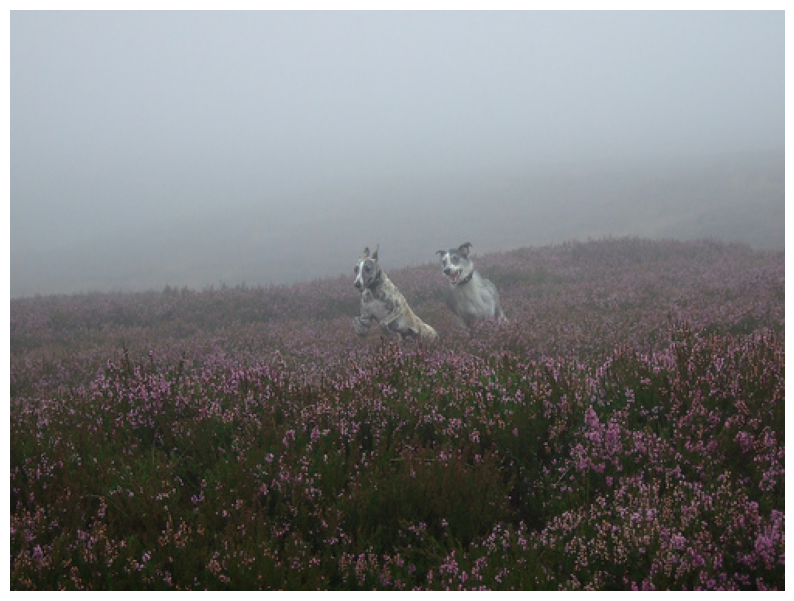

In [19]:
def display_sample_image():
    sample_img_name = random.choice(list(images_captions_dict.keys()))
    image_path = os.path.join(image_directory, sample_img_name)
    
    try:
        # Read and decode the image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        
        # Display the captions
        print("\nCaptions for this image:")
        for caption in images_captions_dict[sample_img_name]:
            print(f"- {caption}")
            
    except Exception as e:
        print(f"Error loading image {sample_img_name}: {e}")

display_sample_image()

### Get images and labels from filenames

In [20]:
def get_images_labels(image_filenames):
    images = []  # TODO: Create an empty list to store images
    labels = []  # TODO: Create an empty list to store labels (captions)
    
    # TODO: Loop through each image filename in image_filenames
    for image_filename in image_filenames:
        # TODO: Retrieve the image features from images_dict using the image filename as key
        if image_filename not in images_features_dict:
            continue
        feature = images_features_dict[image_filename]
        
        # TODO: Retrieve the list of captions (labels) for the image from images_captions_dict
        if image_filename not in images_captions_dict:
            continue
        captions_list = images_captions_dict[image_filename]

        # TODO: Loop through each caption for the image and append the image and caption to lists
        for caption in captions_list:
            images.append(feature)
            labels.append(caption)
            
    return images, labels

### Generate train and test set
This approach divides image_filenames, to avoid same image with different caption in train and test dataset. Also the resulting train test is not shuffled because a tensorflow native method will be used for that aim.

In [22]:
# Split the image filenames into training and testing datasets
# TODO: Get the list of all image filenames
all_image_filenames = list(images_captions_dict.keys())

# TODO: Split the image filenames into training and testing sets (use train_test_split)
X_train_fns, X_test_fns = train_test_split(all_image_filenames, test_size=0.2, random_state=42)

# TODO: Use the function `get_images_labels` to get images and captions for the training set
X_train, y_train_raw = get_images_labels(X_train_fns)

# TODO: Use the function `get_images_labels` to get images and captions for the testing set
X_test, y_test_raw = get_images_labels(X_test_fns)

In [23]:
# Per image 5 captions and 0.2 test split
len(X_train), len(y_train_raw), len(X_test), len(y_test_raw)

(3200, 3200, 800, 800)

### Tokenize train labels
Generate a vocabulary and transform the train captions to a vector with their indices in the vocabulary [1].

In [24]:
# Set the maximum number of words to keep in the vocabulary (top_k = 5000)
top_k = 5000  # TODO: Set the maximum number of words to keep from the vocabulary

# Initialize the Tokenizer, with 'num_words' set to top_k and 'oov_token' as <unk>
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                   oov_token="<unk>",
                                                   filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# TODO: Use the tokenizer to fit on the training captions (y_train_raw) and generate the vocabulary
tokenizer.fit_on_texts(y_train_raw)

# TODO: Tokenize the training captions into sequences (integer representation of words)
train_seqs = tokenizer.texts_to_sequences(y_train_raw)

# TODO: Add padding to each tokenized caption sequence to ensure uniform length
y_train = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

Calculate max caption length which would be the number of hidden layers in the LSTM.

In [25]:
max_caption_length = y_train.shape[1]
vocab_size = min(top_k + 1, len(tokenizer.word_index) + 1)

print("max_caption_length:", max_caption_length)
print("vocab_size:", vocab_size)

max_caption_length: 29
vocab_size: 2456


Example tokenization

In [26]:
# [tokenizer.index_word[i] for i in y_train[1]] # The adding add 0s to the sequences, so need to handle the mapping
[tokenizer.index_word[i] if i != 0 else '<pad>' for i in y_train[1]]

['a',
 'boy',
 'with',
 'a',
 'dirty',
 'face',
 'smiles',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

### Generate Tensorflow dataset
Generate dataset using buffer and batch size that would be used during training. 

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [28]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
NUM_STEPS = BUFFER_SIZE // BATCH_SIZE

# Shuffle and batch

# Using prefetching: https://www.tensorflow.org/guide/data_performance#prefetching
dataset = (dataset
          .shuffle(BUFFER_SIZE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))

## Models Definition

### CNN Encoder

* Flattens the input feature maps into a 1D vector
* Passes through a fully connected layer with ReLU activation to get embeddings
* Returns embeddings of size (batch_size, embedding_dim)

In [29]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(embedding_dim) #, activation='relu')

    def call(self, x):
        x = self.flat(x)
        x = self.fc(x)
        return x

### RNN Decoder

* Uses an Embedding layer to convert caption words to vectors
* Uses LSTM layer for sequence processing with return_sequences=True to get outputs for each timestep
* Uses Dense layer with softmax activation to convert LSTM outputs to word probabilities
* Concatenates image features with word embeddings as input
* Returns LSTM outputs and states for maintaining state between timesteps
* Includes reset_state method to initialize LSTM states

In [30]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        # input_dim = size of the vocabulary
        # Define the embedding layer to transform the input caption sequence
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # Define the Long Short Term Memory layer to predict the next words in the sequence 
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True)
            
        # Define a dense layer to transform the LSTM output into prediction of the best word
        self.fc = tf.keras.layers.Dense(vocab_size) #, activation='softmax')

    # A function that transforms the input embeddings and passes them to the LSTM layer 
    def call(self, captions, features, omit_features = False, initial_state = None, verbose = False):
        if verbose:
            print("Before embedding")
            print(captions.shape)

        embed = self.embedding(captions) #(batch_size, 1, embedding_dim)

        if verbose:
            print("Embed")
            print(embed.shape)

        features = tf.expand_dims(features, 1)
        
        if verbose:
            print("Features")
            print(features.shape)
        
        # Concatenating the image and caption embeddings before providing them to LSTM
        # shape == (batch_size, 1, embedding_dim + hidden_size)
        lstm_input = tf.concat([features, embed], axis=-2) if (omit_features == False) else embed
        
        if verbose:
            print("LSTM input")
            print(lstm_input.shape)

        # Passing the concatenated vector to the LSTM
        output, memory_state, carry_state = self.lstm(lstm_input, initial_state=initial_state)

        if verbose:
            print("LSTM output")
            print(output.shape)

        # Transform LSTM output units to vocab_size
        output = self.fc(output)

        return output, memory_state, carry_state

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

<b>Overall:</b>
* CNN_Encoder processes image features
* RNN_Decoder takes those features and previously generated words to predict the next word
* The process continues until the full caption is generated

## Train Stage

In [57]:
# Set the embedding dimension and number of units for the decoder
units = embedding_dim = 512  # TODO: Set embedding dimension and units for the decoder, matching the paper's configuration
vocab_size = min(top_k + 1, len(tokenizer.word_index.keys()))  # TODO: Define the vocabulary size (top_k + 1)

# TODO: Initialize the encoder and decoder models
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# TODO: Initialize the Adam optimizer for training the model
optimizer = tf.keras.optimizers.Adam()

# Set up the loss function to use SparseCategoricalCrossentropy, with logits as inputs (since they are not probabilities)
# TODO: Define the loss function
def loss_function(real, pred, verbose=False):
    if verbose:
        print(f"Loss function shapes - real: {real.shape}, pred: {pred.shape}")

    real = tf.clip_by_value(real, 0, vocab_size - 1)    
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    # Calculate loss
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    # Apply mask to ignore padding
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


In [58]:
# Key Point: Any Python side-effects (appending to a list, printing with print, etc) will only happen once, when func is traced.
# To have side-effects executed into your tf.function they need to be written as TF ops:
@tf.function
def train_step(img_tensor, target, verbose=False):
    if verbose:
        print(f"Input shapes - img_tensor: {img_tensor.shape}, target: {target.shape}")    
    
    # TODO: Process the target to exclude the last token (<end>) to make room for the start token
    # dec_input = tf.convert_to_tensor(target[:, :-1], dtype=tf.int32)
    # real = tf.convert_to_tensor(target[:, 1:], dtype=tf.int32)
    dec_input = target[:, :-1]  
    real = target[:, 1:]  

    # Bounding
    dec_input = tf.clip_by_value(dec_input, 0, vocab_size - 1)
    real = tf.clip_by_value(real, 0, vocab_size - 1)

    if verbose:
        print(f"Processed shapes - dec_input: {dec_input.shape}, real: {real.shape}")

    # Source: https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as tape:
        # TODO: Pass the image tensor through the encoder to get features
        features = encoder(img_tensor)

        # TODO: Pass the decoder input and features to the decoder
        predictions, _, _ = decoder(dec_input, features)
        
        # TODO: Calculate the loss between the predicted values and the target (caption loss)
        batch_loss = 0
        for t in range(real.shape[1]):
            loss_t = loss_function(real[:, t], predictions[:, t, :])
            batch_loss += loss_t

        # Get average loss
        batch_loss = batch_loss / int(real.shape[1])

    # TODO: Calculate the total and mean batch loss
    total_batch_loss = batch_loss
    mean_batch_loss = total_batch_loss/int(target.shape[1])

    # TODO: Compute gradients for the trainable variables and apply the gradients using the optimizer
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(batch_loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return total_batch_loss, mean_batch_loss

### Checkpoint
Create a tensorflow checkpoint on a local path to save the encoder and decoder state while training. Only the last 5 models would be saved. 

In [64]:
# TODO: Define a path for saving checkpoints (e.g., a directory for storing model states during training)
checkpoint_path = "/home/ctl6998/AdvancedMLDL/checkpoints/train"

# TODO: Initialize a Checkpoint object to save and restore the encoder, decoder, and optimizer states
ckpt = tf.train.Checkpoint(encoder=encoder,
                          decoder=decoder,
                          optimizer=optimizer)

# TODO: Create a CheckpointManager that will handle saving and loading the checkpoint files
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# TODO: Add code for saving and restoring the checkpoint during training
# - Saving checkpoints at regular intervals
# - Restoring the checkpoint if a previously saved model is being resumed from
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restored from checkpoint:", ckpt_manager.latest_checkpoint)

### Start Training

In [65]:
from time import time # Added for tracking

loss_plot = []

In [66]:
print("Tokenizer word index length:", len(tokenizer.word_index))
print("Vocabulary size:", vocab_size)
print("Maximum index in target:", tf.reduce_max(target))

Tokenizer word index length: 2455
Vocabulary size: 2455
Maximum index in target: tf.Tensor(2434, shape=(), dtype=int32)


In [67]:
# TODO: Set the number of epochs for training
EPOCHS = 10

# TODO: Initialize the starting epoch for resuming training from a checkpoint (if applicable)
start_epoch = 0

# TODO: Implement the main training loop over epochs
for epoch in range(start_epoch, EPOCHS):
    real_epoch = len(loss_plot) + 1  # Keep track of the real epoch number (for plotting or display)
    
    # TODO: Track the time taken for each epoch
    start = time()  # Start the timer for the epoch
    total_loss = 0  # Initialize the total loss for the epoch

    # TODO: Implement the training loop for batches within each epoch
    for (batch, (img_tensor, target)) in enumerate(dataset):
        # TODO: Call the training step for each batch
        total_batch_loss, mean_batch_loss = train_step(img_tensor, target, verbose=True)
        
        # TODO: Accumulate the batch loss
        total_loss += total_batch_loss

        # TODO: Print the loss for every 100 batches
        if batch % 100 == 0 and batch > 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {mean_batch_loss.numpy():.4f}')
    
    # TODO: Calculate the total loss and average loss for the epoch
    epoch_loss = total_loss / (batch + 1)

    # TODO: Store the loss value at the end of the epoch for later plotting
    loss_plot.append(epoch_loss.numpy())
    
    # TODO: Save the checkpoint every 5 epochs (or another suitable interval)
    if epoch % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saved checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    # TODO: Print the loss and time taken for each epoch
    print ('Epoch {} Epoch Loss {:.6f}'.format(real_epoch, epoch_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time() - start))


Saved checkpoint for epoch 1 at /home/ctl6998/AdvancedMLDL/checkpoints/train/ckpt-1
Epoch 1 Epoch Loss 1.785835
Time taken for 1 epoch 26.094083547592163 sec

Epoch 2 Epoch Loss 1.701154
Time taken for 1 epoch 25.52306842803955 sec

Epoch 3 Epoch Loss 1.638113
Time taken for 1 epoch 25.267945766448975 sec

Epoch 4 Epoch Loss 1.586474
Time taken for 1 epoch 25.291643381118774 sec

Epoch 5 Epoch Loss 1.541917
Time taken for 1 epoch 25.425584077835083 sec

Saved checkpoint for epoch 6 at /home/ctl6998/AdvancedMLDL/checkpoints/train/ckpt-2
Epoch 6 Epoch Loss 1.500979
Time taken for 1 epoch 25.633041620254517 sec

Epoch 7 Epoch Loss 1.463281
Time taken for 1 epoch 25.47963523864746 sec

Epoch 8 Epoch Loss 1.427136
Time taken for 1 epoch 25.409512519836426 sec

Epoch 9 Epoch Loss 1.392401
Time taken for 1 epoch 25.21659755706787 sec

Epoch 10 Epoch Loss 1.359718
Time taken for 1 epoch 25.244287967681885 sec



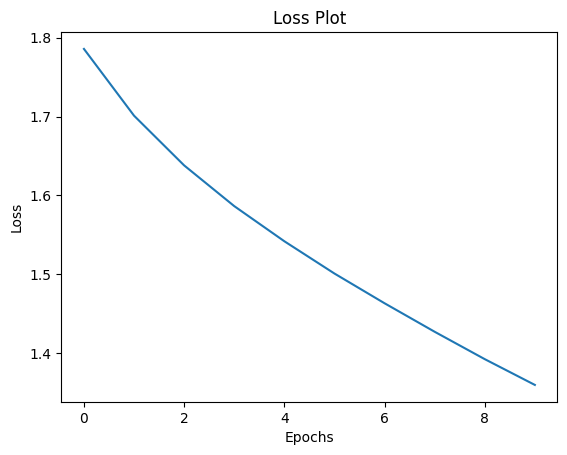

In [68]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Continue from checkpoints with added 50 epoch

In [118]:
# TODO: Set the number of epochs for training
EPOCHS = 50

# TODO: Initialize the starting epoch for resuming training from a checkpoint (if applicable)
start_epoch = 0

# TODO: Implement the main training loop over epochs
for epoch in range(start_epoch, EPOCHS):
    real_epoch = len(loss_plot) + 1  # Keep track of the real epoch number (for plotting or display)
    
    # TODO: Track the time taken for each epoch
    start = time()  # Start the timer for the epoch
    total_loss = 0  # Initialize the total loss for the epoch

    # TODO: Implement the training loop for batches within each epoch
    for (batch, (img_tensor, target)) in enumerate(dataset):
        # TODO: Call the training step for each batch
        total_batch_loss, mean_batch_loss = train_step(img_tensor, target, verbose=True)
        
        # TODO: Accumulate the batch loss
        total_loss += total_batch_loss

        # TODO: Print the loss for every 100 batches
        if batch % 100 == 0 and batch > 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {mean_batch_loss.numpy():.4f}')
    
    # TODO: Calculate the total loss and average loss for the epoch
    epoch_loss = total_loss / (batch + 1)

    # TODO: Store the loss value at the end of the epoch for later plotting
    loss_plot.append(epoch_loss.numpy())
    
    # TODO: Save the checkpoint every 5 epochs (or another suitable interval)
    if epoch % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saved checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    # TODO: Print the loss and time taken for each epoch
    print ('Epoch {} Epoch Loss {:.6f}'.format(real_epoch, epoch_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time() - start))

Saved checkpoint for epoch 1 at /home/ctl6998/AdvancedMLDL/checkpoints/train/ckpt-3
Epoch 11 Epoch Loss 1.328480
Time taken for 1 epoch 30.683372735977173 sec

Epoch 12 Epoch Loss 1.298540
Time taken for 1 epoch 30.343730449676514 sec

Epoch 13 Epoch Loss 1.269129
Time taken for 1 epoch 30.24112582206726 sec

Epoch 14 Epoch Loss 1.240597
Time taken for 1 epoch 30.219393014907837 sec

Epoch 15 Epoch Loss 1.210988
Time taken for 1 epoch 30.16147804260254 sec

Saved checkpoint for epoch 6 at /home/ctl6998/AdvancedMLDL/checkpoints/train/ckpt-4
Epoch 16 Epoch Loss 1.182735
Time taken for 1 epoch 30.75828242301941 sec

Epoch 17 Epoch Loss 1.153086
Time taken for 1 epoch 30.30694007873535 sec

Epoch 18 Epoch Loss 1.124127
Time taken for 1 epoch 30.182904720306396 sec

Epoch 19 Epoch Loss 1.095594
Time taken for 1 epoch 30.25246810913086 sec

Epoch 20 Epoch Loss 1.067491
Time taken for 1 epoch 30.20340323448181 sec

Saved checkpoint for epoch 11 at /home/ctl6998/AdvancedMLDL/checkpoints/train/

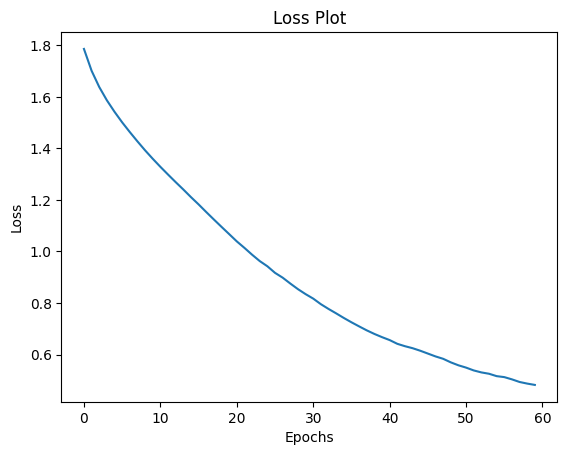

In [119]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Test Stage

### Evaluate random image

In [69]:
# Remove <start>, <end> and <pad> marks from the predicted sequence
def clean_caption(caption):
    return [item for item in caption if item not in ['<start>', '<end>', '<pad>']]

In [115]:
# test_img_name = random.choice(image_filenames_train)
test_img_name = random.choice(list(images_captions_dict.keys()))
test_img_path = os.path.join(image_directory, test_img_name)
print(test_img_name)
print(test_img_path)

1472249944_d887c3aeda.jpg
/home/ctl6998/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images/1472249944_d887c3aeda.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Real captions:
A girl in a pink shirt is riding a bicycle in traffic .
An Asian woman rides a bicycle in front of two cars .
A woman in a pink sweater rides her bike alongside cars .
A woman is riding her bicycle down the street .
A woman wearing a pink sweater rides a bike with a car behind her .
Estimated caption:
['man', 'on', 'looking', 'at', 'ride', 'shows', 'one', 'wearing', 'sits', 'riding', 'bike', 'and', 'off', 'fishing', 'into', 'distance', 'a', 'sign', 'one', 'while', 'child', 'on', 'skateboard', 'the', 'at', 'with', 'in', 'background']


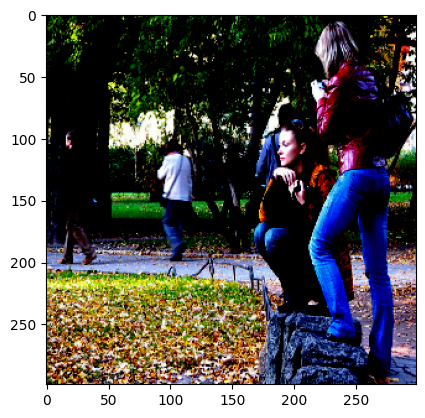

In [120]:
# TODO: Get captions from a test image
def get_caption(img):    
    # Add the image to an array to simulate batch size of 1
    features = encoder(tf.expand_dims(img, 0))
    
    caption = []
    dec_input = tf.expand_dims([], 0)
    
    # Inputs the image embedding into the trained LSTM layer and predict the first word of the sequence
    # The output, hidden, and cell states are passed again to the LSTM to generate the next word.
    # The iteration is repeated until the caption does not reach the max length.
    state = None
    for i in range(1, max_caption_length):
        # TODO: Call the decoder with the current input and get predictions
        predictions, memory_state, carry_state = decoder(dec_input, features, omit_features=i > 1, initial_state=state)

        word_index = np.argmax(predictions.numpy().flatten())

        caption.append(tokenizer.index_word[word_index])

        dec_input = tf.expand_dims([word_index], 0)       
        state = [memory_state, carry_state]
    
    # Clean up the caption by removing <start>, <end>, and <pad> tokens
    return clean_caption(caption)

# Example to use the get_caption function
raw_img = load_image(test_img_path)[0]
img = images_features_dict[test_img_name]
captions = images_captions_dict[test_img_name]

plt.imshow(raw_img)

print("Real captions:")
for caption in captions:
    print(caption)

print("Estimated caption:")
estimated_caption = get_caption(img)
print(estimated_caption)


### Evaluate dataset using BLEU

Evaluation result from 60 epoch

In [121]:
# TODO: Get a caption for a test image by generating a sequence of words
def get_caption(img):    
    # TODO: Add image to an array to simulate batch size of 1  
    features = encoder(tf.expand_dims(img, 0))

    caption = []  # Initialize an empty list to store generated words
    dec_input = tf.expand_dims([], 0)  # Initialize decoder input as an empty tensor
    
    # TODO: Initialize the state as None to start the RNN (LSTM)
    state = None
    
    # TODO: Generate the caption word-by-word up to the maximum caption length
    for i in range(1, max_caption_length):
        predictions, memory_state, carry_state = decoder(dec_input, features, omit_features=i > 1, initial_state=state)  # Get predictions from the decoder

        # TODO: Convert the predictions into a word index (most probable word)
        word_index = np.argmax(predictions.numpy().flatten())  # Choose the most likely word
        
        # TODO: Append the word corresponding to the index to the caption list
        caption.append(tokenizer.index_word[word_index])

        # TODO: Update the decoder input for the next iteration with the predicted word
        dec_input = tf.expand_dims([word_index], 0)  # Set the input to the decoder as the predicted word
        state = [memory_state, carry_state]  # Update the LSTM state for the next iteration
    
    # TODO: Clean the caption to remove unwanted tokens (<start>, <end>, <pad>)
    return clean_caption(caption)

# Lists to store the actual and predicted captions
actual, predicted = [], []

# TODO: Loop over the test image filenames and generate captions
image_filenames_test = X_test_fns
for test_img_name in image_filenames_test:
    # TODO: Load the image
    img = images_features_dict[test_img_name]
    
    # TODO: Generate the caption using the model
    estimated_caption = get_caption(img)

    # TODO: Clean the actual captions by removing the <start>, <end>, <pad> tokens
    captions = [clean_caption(caption.split()) for caption in images_captions_dict[test_img_name]]
    
    # TODO: Store the actual and predicted captions in separate lists
    actual.append(captions)
    predicted.append(estimated_caption)

# TODO: Compute and print BLEU scores to evaluate the caption generation
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))  # BLEU-1 for unigrams
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))  # BLEU-2 for bigrams
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))) # BLEU-3 for trigrams
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))) # BLEU-4 for 4-grams


BLEU-1: 0.208482
BLEU-2: 0.033316
BLEU-3: 0.000000
BLEU-4: 0.000000


## Discussion

#### **BLEU-1 (0.208482): Overlap of unigrams (single words) between generated and reference captions.**

##### Explain:
- The model correctly reproduces ~20.84% of individual words from the reference captions.
- This suggests the model can identify basic objects/actions (e.g., *"dog," "run," "tree"*) but struggles with context or grammar.

##### Common causes:
- Limited vocabulary diversity in training data.
- Over-reliance on frequent words (e.g., articles like *"a," "the"*).


---


#### **BLEU-2 (0.033316): Overlap of bigrams (word pairs) between generated and reference captions.**

##### Explain:
- A score of **3.33%** indicates the model rarely produces correct two-word phrases (e.g., *"black dog," "climbing stairs"*).
- This suggests poor syntactic structure (word order) and lack of contextual coherence.

##### Common causes:
- Weakness in the LSTM’s ability to model sequential dependencies.
- Insufficient training on phrase-level patterns.


---


#### **BLEU-3 and BLEU-4 (0.000000): Overlap of trigrams (3-word sequences) and 4-grams (4-word sequences).**

##### Observation:
- Scores of **0%** mean the model fails to generate meaningful multi-word phrases.
- Generated captions are likely:
  - **Too short** (e.g., missing critical details).
  - **Grammatically incoherent** (e.g., *"dog running tree park"*).
  - **Repetitive** (e.g., *"dog dog dog"*).

##### Common causes:
- Decoding strategy issues.
- Limited training data for complex sentence structures.


---


#### **Conclusion**
- The model performs **acceptably at the word level (BLEU-1)** but fails to generate coherent sentences, reflected in poor BLUE-2/3/4 score. Addressing **sequential modeling (via architecture changes)** and improving **decoding strategies** would likely boost BLEU-2/3/4 scores.
- Small epoch testing = The LSTM lack learn long-term dependencies, CNN encoder extract less features, model is not fully converged.
- The dataset (Flickr 8K) might be too small for robust generalization.